# Using Individual Google Trends data as a predictor for Individual Travel Website Stock Returns

## Installing & Loading Necessary Packages 


In [1]:
install.packages("rvest") #A Web-Scrapping Package
install.packages("magrittr")
install.packages("stringr")
install.packages("quantmod")
install.packages("RMySQL")
install.packages("dplyr")

library(rvest)
library(magrittr)
library(stringr)
library(quantmod)
library(RMySQL)
library(dplyr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: DBI


Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The foll

## Loading the scrapped data from Google Trends

In [2]:
queryMySQL = function(statement) {
  con = dbConnect(MySQL(), host = "147.8.122.231", user = "fina_4359_u3548379", password = "856e7")
  response = dbGetQuery(con,statement)
  dbDisconnect(con)

  return(response)  
}

queryMySQL("show tables in writeable_fina_4359_u3548379")

#lapply(dbListConnections(dbDriver( drv = "MySQL")), dbDisconnect)

Tables_in_writeable_fina_4359_u3548379
<chr>
Boxoffice_weekly_revenue
JETS
TSA
alexarank_daily_by_individual_companies
alexarank_daily_cummulative
alexarank_weekly_cummulative
google_trends_weekly_data
visits


In [3]:
con = dbConnect(MySQL(), host = "147.8.122.231", user = "fina_4359_u3548379", password = "856e7", dbname = "writeable_fina_4359_u3548379")
g_trends = queryMySQL("select * from writeable_fina_4359_u3548379.google_trends_weekly_data")

In [4]:
g_trends$date = substr(g_trends$date,1,10)
g_trends$date = as.Date(g_trends$date)
head(g_trends)

,date,Tripadvisor,Booking,Trip,Expedia,Hotels,Airbnb,Agoda,Priceline,Skyscanner,Trivago,Average,Sum
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-05-23,78,54,8,85,81,56,85,92,52,54,64.5,645
2,2016-05-30,81,57,11,84,81,55,85,89,52,53,64.8,648
3,2016-06-06,80,57,9,86,82,59,84,95,52,56,66.0,660
4,2016-06-13,81,59,8,88,83,57,80,95,52,59,66.2,662
5,2016-06-20,82,61,9,93,91,61,81,95,57,61,69.1,691
6,2016-06-27,86,67,10,95,100,62,86,100,60,71,73.7,737


## Downloading Individual Stock Data

In [5]:
websites=c("Tripadvisor", "Booking","Trip", "Expedia","Hotels", "Airbnb", "Agoda", "Priceline", "Skyscanner", "Trivago")
website = websites[7]
tickers = c("TRIP", "BKNG", "ABNB", "EXPE", "TRVG")

chosen <- 
    if (website == "Tripadvisor" || website == "Trip" ) "TRIP" else
    if (website == "Booking" || website == "Agoda" || website == "Priceline" || website == "Skyscanner") "BKNG" else
    if (website == "Expedia" || website == "Hotels")  "EXPE" else
    if (website == "Airbnb")  "ABNB" else
    if (website == "Trivago")  "TRVG" else
    "Unknown combination"
print(paste("Chosen Ticker:",chosen))

getSymbols(chosen)
ticker = eval(parse(text=chosen))[,-c(1:5)]
colnames(ticker)[1] = "price"

adj_JETS = data.frame(date = as.Date("1990-01-01"), price = 0)
for (num_row in 1:nrow(ticker)) {
  adj_JETS[num_row,1] = index(ticker)[num_row]
  adj_JETS[num_row,2] = ticker[num_row,1]
}

tail(adj_JETS)

[1] "Chosen Ticker: BKNG"


‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.




[1] "BKNG"

,date,price
,<date>,<dbl>
3621,2021-05-20,2306.05
3622,2021-05-21,2293.38
3623,2021-05-24,2348.48
3624,2021-05-25,2339.01
3625,2021-05-26,2347.00
3626,2021-05-27,2334.78


## Downloading S&P 500 Data

In [6]:
getSymbols("^GSPC")

SPX = GSPC[,-c(1:5)]
colnames(SPX)[1] = "price"

adj_SPX = data.frame(date = as.Date("1990-01-01"), price = 0)
for (num_row in 1:nrow(SPX)) {
  adj_SPX[num_row,1] = index(SPX)[num_row]
  adj_SPX[num_row,2] = SPX[num_row,1]
}

tail(adj_SPX)

[1] "^GSPC"

,date,price
,<date>,<dbl>
3621,2021-05-20,4159.12
3622,2021-05-21,4155.86
3623,2021-05-24,4197.05
3624,2021-05-25,4188.13
3625,2021-05-26,4195.99
3626,2021-05-27,4200.88


## Downloading Risk-Free Rate (10Y US Govn't Treasuries Yield)

In [7]:
getSymbols("DGS10", src = "FRED")

rf = data.frame(date = as.Date("1990-01-01"), yield = 0)


for (num_row in 1:nrow(DGS10)) {
  rf[num_row,1] = index(DGS10)[num_row]
  rf[num_row,2] = DGS10[num_row,1]
}

#Linearly Interpolating Missing Value
  
for (num_row in 2:nrow(rf)) {
  if (is.na(rf[num_row,2]) == TRUE) {
    rf[num_row,2] = (rf[num_row-1,2] + rf[num_row+1,2])/2
  }
}

head(rf)

[1] "DGS10"

,date,yield
,<date>,<dbl>
1,1962-01-02,4.06
2,1962-01-03,4.03
3,1962-01-04,3.99
4,1962-01-05,4.02
5,1962-01-08,4.03
6,1962-01-09,4.05


## Merging Daily Individual Stock data & Google Trends Data

In [8]:
g_trends_cummulative = g_trends %>% select(date,website,Sum)
# g_trends_cummulative[website] = g_trends[website]
head(g_trends_cummulative)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(website)` instead of `website` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



,date,Agoda,Sum
,<date>,<dbl>,<dbl>
1,2016-05-23,85,645
2,2016-05-30,85,648
3,2016-06-06,84,660
4,2016-06-13,80,662
5,2016-06-20,81,691
6,2016-06-27,86,737


In [9]:
merge(adj_JETS, g_trends_cummulative, by = "date", all.x = TRUE) %>% merge(adj_SPX, by = "date", all.x = TRUE) %>% merge(rf, by = "date", all.x = TRUE) -> regression_data
colnames(regression_data)[c(2,5)] = c(paste(chosen,"_price",sep=""), "SPX")
head(regression_data)

,date,BKNG_price,Agoda,Sum,SPX,yield
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2007-01-03,43.97,NA,NA,1416.60,4.67
2,2007-01-04,44.44,NA,NA,1418.34,4.62
3,2007-01-05,43.87,NA,NA,1409.71,4.65
4,2007-01-08,43.76,NA,NA,1412.84,4.66
5,2007-01-09,44.06,NA,NA,1412.11,4.66
6,2007-01-10,44.84,NA,NA,1414.85,4.69


## Transform Daily Data into Weekly Data

In [10]:
temp_JETS <- as.xts(regression_data[paste(chosen,"_price",sep="")], order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof") 
temp_JETS <- temp_JETS["2019-12-23/2021"]

temp_SPX <- as.xts(regression_data$SPX, order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof") 
temp_SPX <- temp_SPX["2019-12-23/2021"]

temp_yield <- as.xts(regression_data$yield, order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof")
temp_yield <- temp_yield["2019-12-23/2021"]

temp_g_trends <- as.xts(g_trends_cummulative[website], order.by = as.Date(g_trends_cummulative$date)) %>% to.weekly(indexAt = "startof")
temp_g_trends <- temp_g_trends["2019-12-23/2021"]

temp_g_trends_sum <- as.xts(g_trends_cummulative$Sum, order.by = as.Date(g_trends_cummulative$date)) %>% to.weekly(indexAt = "startof")
temp_g_trends_sum <- temp_g_trends_sum["2019-12-23/2021"]

regression_data_weekly = data.frame(date = as.Date("1990-01-01"), placeholder_name = 0, Google_Trends =0, Google_Trends_Sum =0, SPX = 0, yield = 0)

for (i in 1:nrow(temp_g_trends)) {
  regression_data_weekly[i,1] = index(temp_g_trends)[i]  
  regression_data_weekly[i,2] = temp_JETS[i,4]
  regression_data_weekly[i,3] = temp_g_trends[i,1]
  regression_data_weekly[i,4] = temp_g_trends_sum[i,1]
  regression_data_weekly[i,5] = temp_SPX[i,1]
  regression_data_weekly[i,6] = temp_yield[i,1]
}

if (Sys.Date() >= regression_data_weekly[nrow(temp_g_trends),1]) {
  regression_data_weekly <- regression_data_weekly[-nrow(temp_g_trends),]
}

names(regression_data_weekly)[names(regression_data_weekly) == "placeholder_name"] <- paste(chosen,"_closing_price",sep="")
head(regression_data_weekly,200)

#Consider trying 2020-04-06

Warning message in to.period(x, "weeks", name = name, ...):
“missing values removed from data”


,date,BKNG_closing_price,Google_Trends,Google_Trends_Sum,SPX,yield
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-12-23,2072.54,91,639,3224.01,1.93
2,2019-12-30,2065.48,85,708,3221.29,1.90
3,2020-01-06,2086.90,81,727,3246.28,1.81
4,2020-01-13,2054.69,79,722,3288.13,1.85
5,2020-01-20,1962.96,75,680,3320.79,1.78
6,2020-01-27,1830.55,64,645,3243.63,1.61
7,2020-02-03,1909.59,65,636,3248.92,1.54
8,2020-02-10,1990.96,64,636,3352.09,1.56
9,2020-02-17,1928.72,67,632,3370.29,1.55


# Prepare Data for Regression

In [11]:
to_regress = data.frame(date = as.Date("1990-01-01"), JETS_weekly_return = 0, Google_Trends_Weekly_Change =0, SPX_weekly_return = 0,JETS_weekly_excess_return=0,	SPX_weekly_excess_return =0, JETS_rebased = 0, Google_Trends_rebased=0, SPX_rebased=0)
for(i in 1:nrow(regression_data_weekly))
{
   if (i == 1) {
      to_regress[i,1] = regression_data_weekly[i,1]
      to_regress[i,7] = 1
      to_regress[i,8] = 1
      to_regress[i,9] = 1
    } 
    else{
 to_regress[i,1] = regression_data_weekly[i,1]
 to_regress[i,2] = (regression_data_weekly[i,2]-regression_data_weekly[i-1,2])/regression_data_weekly[i-1,2]
 to_regress[i,3] = (regression_data_weekly[i,3]-regression_data_weekly[i-1,3])/regression_data_weekly[i-1,3]
 #to_regress[i,4] = (regression_data_weekly[i,4]-regression_data_weekly[i-1,4])/regression_data_weekly[i-1,4]
 to_regress[i,4] = (regression_data_weekly[i,5]-regression_data_weekly[i-1,5])/regression_data_weekly[i-1,5]
 to_regress[i,5] = (regression_data_weekly[i,2]-regression_data_weekly[i-1,2])/regression_data_weekly[i-1,2] - regression_data_weekly[i,6]/52/100
 to_regress[i,6] = (regression_data_weekly[i,5]-regression_data_weekly[i-1,5])/regression_data_weekly[i-1,5] - regression_data_weekly[i,6]/52/100
 to_regress[i,7] = to_regress[i-1,7] * (1 + to_regress[i,2])
 to_regress[i,8] = to_regress[i-1,8] * (1 + to_regress[i,3])
 to_regress[i,9] = to_regress[i-1,9] * (1 + to_regress[i,4])
    }
}
names(to_regress)[names(to_regress) == "JETS_weekly_return"] <- paste(chosen,"_weekly_return",sep="")
names(to_regress)[names(to_regress) == "JETS_weekly_excess_return"] <- paste(chosen,"_weekly_excess_return",sep="")
names(to_regress)[names(to_regress) == "JETS_rebased"] <- paste(chosen,"_rebased",sep="")
head(to_regress,20)


,date,BKNG_weekly_return,Google_Trends_Weekly_Change,SPX_weekly_return,BKNG_weekly_excess_return,SPX_weekly_excess_return,BKNG_rebased,Google_Trends_rebased,SPX_rebased
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-12-23,0.000000000,0.00000000,0.0000000000,0.000000000,0.000000000,1.0000000,1.0000000,1.0000000
2,2019-12-30,-0.003406477,-0.06593407,-0.0008436608,-0.003771861,-0.001209045,0.9965935,0.9340659,0.9991563
3,2020-01-06,0.010370433,-0.04705882,0.0077577584,0.010022356,0.007409682,1.0069286,0.8901099,1.0069076
4,2020-01-13,-0.015434358,-0.02469136,0.0128916340,-0.015790128,0.012535865,0.9913873,0.8681319,1.0198882
5,2020-01-20,-0.044644196,-0.05063291,0.0099327451,-0.044986503,0.009590437,0.9471276,0.8241758,1.0300185
6,2020-01-27,-0.067454209,-0.14666667,-0.0232354816,-0.067763825,-0.023545097,0.8832399,0.7032967,1.0060855
7,2020-02-03,0.043178233,0.01562500,0.0016309009,0.042882079,0.001334747,0.9213766,0.7142857,1.0077264
8,2020-02-10,0.042611239,-0.01538462,0.0317552197,0.042311239,0.031455220,0.9606376,0.7032967,1.0397269
9,2020-02-17,-0.031261297,0.04687500,0.0054294337,-0.031559374,0.005131357,0.9306069,0.7362637,1.0453721


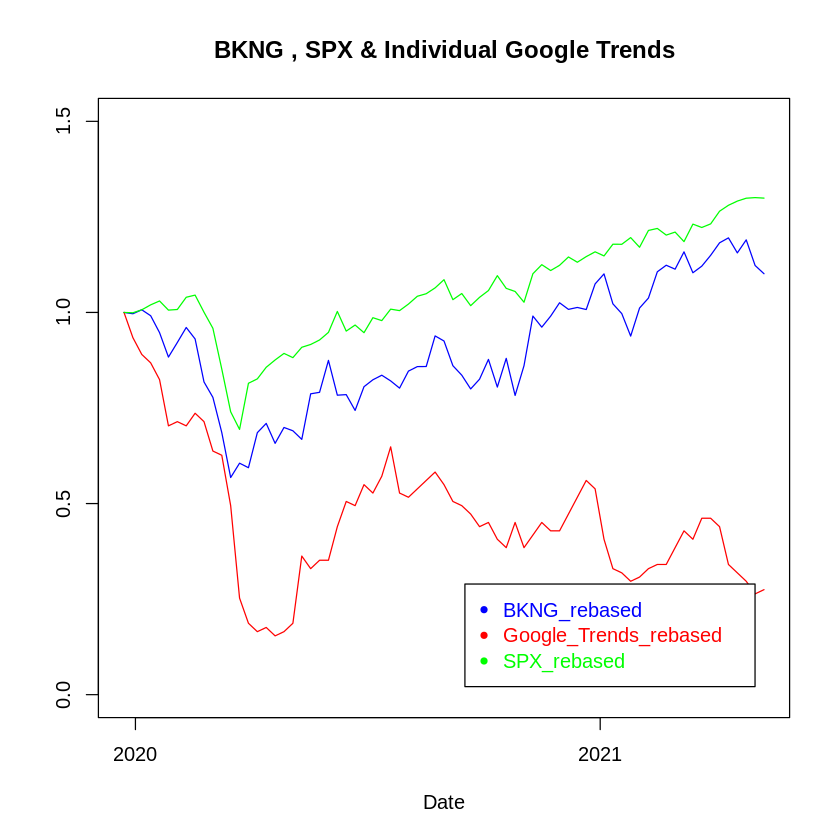

In [12]:
plot(x = to_regress[,1], y = to_regress[,7], type = "l", col = "blue", ylim = c(0,1.5), xlab = "Date", ylab = "", main = paste(chosen,", SPX & Individual Google Trends"))
lines(x = to_regress[,1], y = to_regress[,8], type = "l", col = "red")
lines(x = to_regress[,1], y = to_regress[,9], type = "l", col = "green")
legend("bottomright", 
        legend = colnames(to_regress)[7:9], 
        col = c("blue", "red", "green"),  
        pch = 20, 
        bty = "o", 
        pt.cex = 1, 
        cex = 1, 
        text.col = c("blue", "red", "green"), 
        inset = c(0.05, 0.05))

## Regressing Arithmetic Weekly Individual Stock Return - CAPM


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 6])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.12821 -0.03799 -0.00160  0.02879  0.17360 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)  
(Intercept)      0.00160    0.00748   0.214   0.8312  
to_regress[, 6]  0.38730    0.19779   1.958   0.0541 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06353 on 71 degrees of freedom
Multiple R-squared:  0.05124,	Adjusted R-squared:  0.03787 
F-statistic: 3.834 on 1 and 71 DF,  p-value: 0.05414


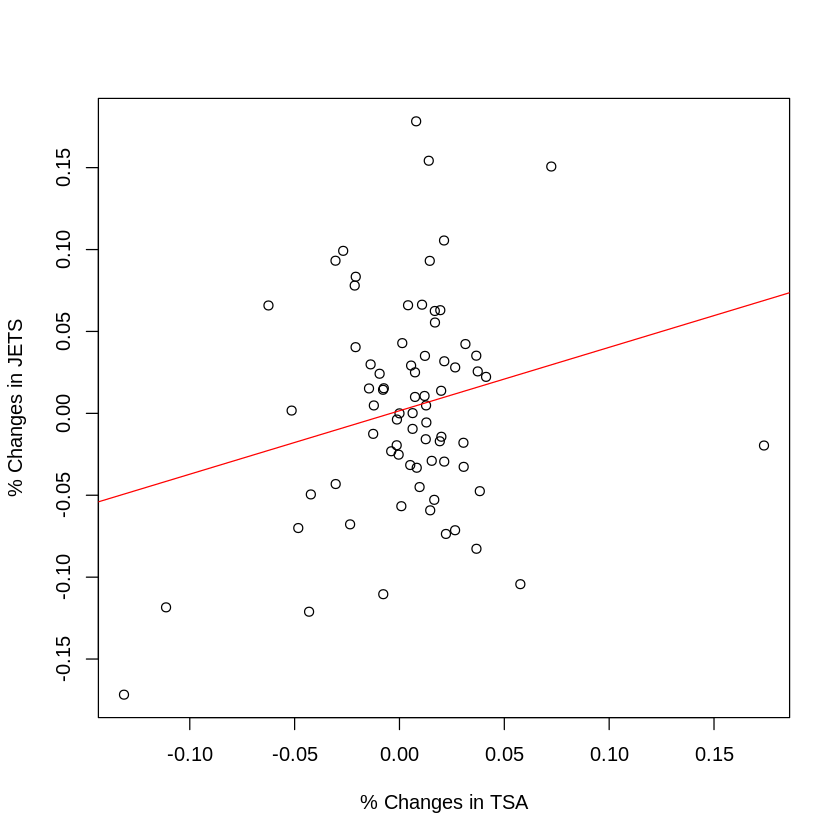

In [ ]:
lm_result_1 = lm(to_regress[,5] ~ to_regress[,6]) # i.e. CAPM
summary(lm_result_1)

plot(to_regress[,5] ~ to_regress[,6], xlab = "% Changes in TSA", ylab = "% Changes in JETS")
abline(lm_result_1, col="red")

## Regressing Arithmetic Weekly Individual Stock Return - Google Trends

In [ ]:
lm_result_2 = lm(to_regress[,5] ~ to_regress[,3])
summary(lm_result_2)


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 3])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.176702 -0.034289 -0.000131  0.032653  0.174356 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)      0.003136   0.007638   0.411    0.683
to_regress[, 3] -0.008670   0.047612  -0.182    0.856

Residual standard error: 0.06521 on 71 degrees of freedom
Multiple R-squared:  0.0004668,	Adjusted R-squared:  -0.01361 
F-statistic: 0.03316 on 1 and 71 DF,  p-value: 0.856


## Regressing Arithmetic Weekly Individual Stock Return - "Improved CAPM with Google Trends"

In [ ]:
lm_result_3 = lm(to_regress[,5] ~ to_regress[,6] + to_regress[,3]) #"Improved Version 1"
summary(lm_result_3)


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 6] + to_regress[, 
    3])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.125159 -0.037029 -0.000465  0.028810  0.171703 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)  
(Intercept)      0.001418   0.007532   0.188   0.8512  
to_regress[, 6]  0.400215   0.200855   1.993   0.0502 .
to_regress[, 3] -0.021742   0.047105  -0.462   0.6458  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06389 on 70 degrees of freedom
Multiple R-squared:  0.05412,	Adjusted R-squared:  0.02709 
F-statistic: 2.002 on 2 and 70 DF,  p-value: 0.1427
